# Prepare The Files

In [ ]:
!unzip -q '/content/drive/MyDrive/Graduation/AI Team/Tasks/2023-09-Sprint2/Digit_Recognition.zip' -d '/content/'

# Load The Libraries

In [ ]:
import os
import json
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import clear_output

---------

# Load The Data

In [ ]:
with open('/content/labels.json', 'r') as f:
    data = json.load(f)

labels = data['labels']
image_dir = '/content/Data/'

images = []
image_labels = []
progress = 0

for label_data in labels:
  filename = os.path.join(image_dir, label_data['filename'])
  label = label_data['label']

  image = Image.open(filename)
  image_array = np.array(image).flatten()

  images.append(image_array)
  image_labels.append(label)

  progress += 1
  if progress % 100 == 0:
    print(f'Progress: {progress} / 8000')

images = np.array(images, dtype=np.float64)
image_labels = np.array(image_labels)

clear_output()
print('Loading Complete')

Loading Complete


In [ ]:
image_labels = image_labels.reshape((8000, 1))
images /= 255

In [ ]:
print(images.shape, images.dtype)
print(image_labels.shape, image_labels.dtype)

(8000, 784) float64
(8000, 1) int64


[9]


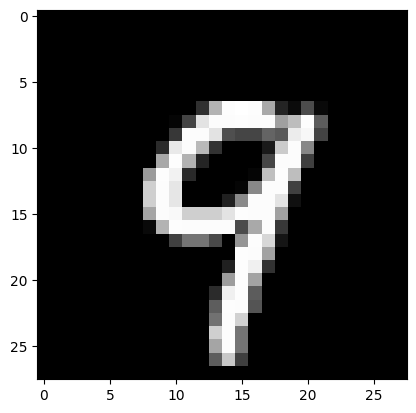

In [ ]:
plt.imshow(images[12].reshape(28, 28) * 255, cmap='gray')
print(image_labels[12])

---------------

# Divide The Data

In [ ]:
train_ratio = 0.6
eval_ratio = 0.2
test_ratio = 0.2

#permutate indexes
sh_index = np.random.permutation(image_labels.shape[0])
images = images[sh_index, :]
image_labels = image_labels[sh_index, :]

# train data
train_size = int(train_ratio * images.shape[0])
train_images = images[:train_size]
train_labels = image_labels[:train_size]

# eval data
eval_size = int(eval_ratio * images.shape[0])
eval_images = images[train_size:train_size + eval_size]
eval_labels = image_labels[train_size:train_size + eval_size]

# test data
test_images = images[train_size + eval_size:]
test_labels = image_labels[train_size + eval_size:]

print(f'Train: {train_images.shape}, {train_labels.shape}')
print(f'Eval: {eval_images.shape}, {eval_labels.shape}')
print(f'Test: {test_images.shape}, {test_labels.shape}')

Train: (4800, 784), (4800, 1)
Eval: (1600, 784), (1600, 1)
Test: (1600, 784), (1600, 1)


--------------

# Build The Model

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
model = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(784,)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(
  optimizer='adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                       

# Test The Model

In [ ]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/models/model_checkpoint_epoch_{epoch:02d}.h5',
    save_best_only=False,
    save_weights_only=False,
    verbose=0
)

history = model.fit(
    train_images,
    train_labels,
    epochs=200,
    validation_data=(eval_images, eval_labels),
    callbacks=[checkpoint_callback]
)

Epoch 1/200
150/150 [==============================] - 2s 6ms/step - loss: 1.0699 - accuracy: 0.6585 - val_loss: 0.6706 - val_accuracy: 0.8519
Epoch 2/200
150/150 [==============================] - 1s 5ms/step - loss: 0.5406 - accuracy: 0.8350 - val_loss: 0.3129 - val_accuracy: 0.9194
Epoch 3/200
150/150 [==============================] - 1s 6ms/step - loss: 0.4196 - accuracy: 0.8750 - val_loss: 0.2577 - val_accuracy: 0.9294
Epoch 4/200
150/150 [==============================] - 0s 3ms/step - loss: 0.3442 - accuracy: 0.8915 - val_loss: 0.2393 - val_accuracy: 0.9369
Epoch 5/200
150/150 [==============================] - 0s 3ms/step - loss: 0.2921 - accuracy: 0.9069 - val_loss: 0.2531 - val_accuracy: 0.9287
Epoch 6/200
150/150 [==============================] - 0s 3ms/step - loss: 0.2668 - accuracy: 0.9158 - val_loss: 0.2260 - val_accuracy: 0.9325
Epoch 7/200
150/150 [==============================] - 1s 3ms/step - loss: 0.2242 - accuracy: 0.9302 - val_loss: 0.2099 - val_accuracy: 0.9369

# Plot The Loss

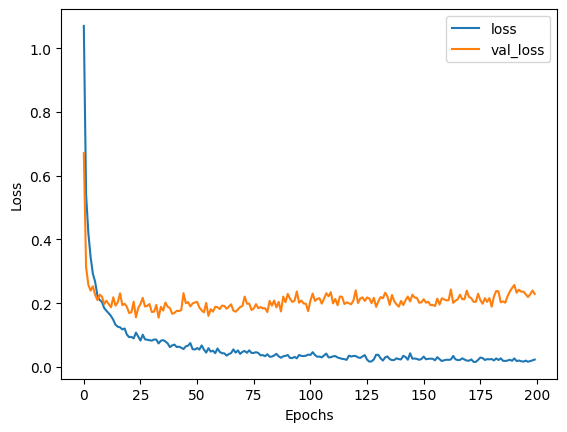

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot The Accuracy

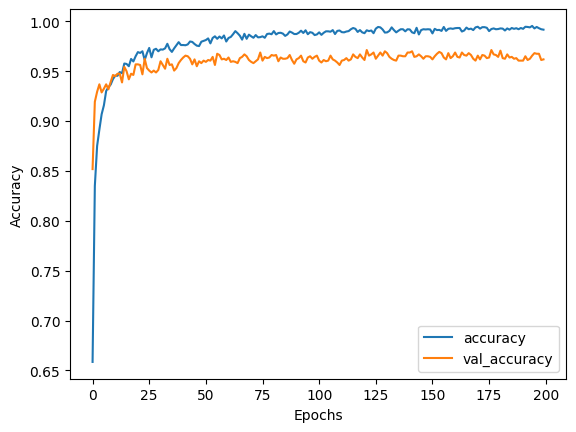

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Choosing The Best Model

In [ ]:
epoch_to_load = 49
best_model = tf.keras.models.load_model(f'/content/models/model_checkpoint_epoch_{epoch_to_load:02d}.h5')

# Testing The Model On The Test Set

In [ ]:
test_loss, test_acc = best_model.evaluate(test_images, test_labels)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')

50/50 [==============================] - 0s 2ms/step - loss: 0.1756 - accuracy: 0.9631
Test Loss: 0.17560197412967682
Test Accuracy: 0.9631249904632568


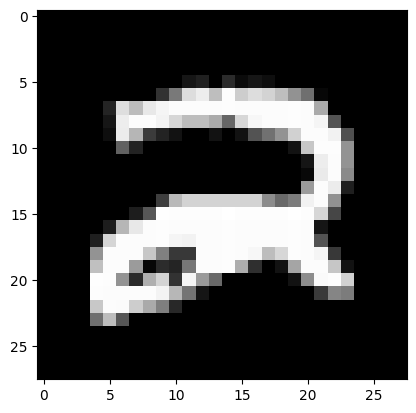

1/1 [==============================] - 0s 130ms/step
Predicted Label: 2
Actual Label: 2


In [ ]:
random_index = np.random.randint(0, test_images.shape[0])
random_image = test_images[random_index]
random_label = test_labels[random_index][0]

plt.imshow(random_image.reshape(28, 28) * 255, cmap='gray')
plt.show()

random_image = random_image.reshape(1, 784)
prediction = best_model.predict(random_image)
print(f'Predicted Label: {np.argmax(prediction)}')
print(f'Actual Label: {random_label}')

# Save The Model

In [ ]:
best_model.save('/content/kamel_model.h5')
!rm -rf '/content/models/'

# Model API

50/50 [==============================] - 0s 2ms/step - loss: 0.2757 - accuracy: 0.9481
Test Loss: 0.27574318647384644
Test Accuracy: 0.9481250047683716


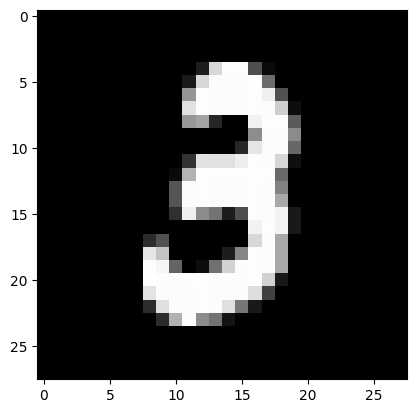

1/1 [==============================] - 0s 126ms/step
Predicted Label: 3
Actual Label: 3


In [ ]:
# test_images = (m, 784)  numpy array   (flatten the image)
# test_labels = (m, 1)    numpy array
model_dir = '/content/kamel_model.h5' # model directory

if model is None:
  print('Model not found.')

else:
  test_loss, test_acc = model.evaluate(test_images, test_labels)
  print(f'Test Loss: {test_loss}')
  print(f'Test Accuracy: {test_acc}')

  random_index = np.random.randint(0, test_images.shape[0])
  random_image = test_images[random_index]
  random_label = test_labels[random_index][0]

  plt.imshow(random_image.reshape(28, 28) * 255, cmap='gray')
  plt.show()

  random_image = random_image.reshape(1, 784)
  prediction = model.predict(random_image)
  print(f'Predicted Label: {np.argmax(prediction)}')
  print(f'Actual Label: {random_label}')